# Test loading elevation maps

TODO:
* Pad the maps out to largest possible ROI.
* Design new grid rotated clockwise 30 deg
* Smooth padded grid before interpolating?
* Interpolate from padded grid to smaller, rotated ROI
* Stack all maps
* Save
    

In [1]:
import json
import fiona
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import rasterio # rasterio and OGR don't mix...see rasterio docs
from rasterio import Affine
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [2]:
# top left corner of big region of interest (UTM Zone 19N meters)
e0 = 376200.; n0 = 4625500.

# size of big roi (colums, rows). divide by 10 to get meters
xsize, ysize = 15000, 10000



In [3]:

fdir = "F:/2017_Karen_Sandwich_maps"
fnames = (\
"2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif",\
"2016-01-25_SandwichTNB_DEM_10cm_trimmed.tif")
# "2016-02-11_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2016-03-30_SandwichTNB_AS_DEM_10cm_trimmed.tif",\
# "2016-09-21_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2017-01-09_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2017-01-25_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2017-02-14_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2017-03-16_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2017-04-28_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2017-05-04_SandwichTNB_DEM_10cm_trimmed.tif",\
# "2017-09-18_SandwichTNB_DEM_10cm_trimmed.tif",\
# #"2018-01-03_SandwichTNB_DEM_10cm_trimmed.tif",\ # needs to be padded...not very good control
# "2018-01-10_SandwichTNB_DEM_10cm_trimmed.tif",\
# "DEM_10cm_selfcal_lokicampos_mid_denseNAD83UTM19.tif")

dslist =[]
fn = fdir+"/2016-01-22_SandwichTNB_PT_DEM_10cm_trimmed.tif"
ds = xr.open_rasterio(fn)
#     ds = ds.sel(x=slice(e0,e1), y=slice(n0,n1))
#     if len(dslist) == 0:
#         xc = ds['x']-ds['x'].values.min()
#         yc = ds['y']-ds['y'].values.min()
#     ds['x'] = xc
#     ds['y'] = yc
#     dslist.append(ds)

In [4]:
ds['x'].values.min()
ds['y'].values.min()
print(ds.sizes)
print(ds.dims)
print(ds.indexes)

Frozen(OrderedDict([('band', 1), ('y', 10226), ('x', 11987)]))
('band', 'y', 'x')
band: Int64Index([1], dtype='int64', name='band')
y: Float64Index([ 4625440.784410301,    4625440.6844103, 4625440.5844103005,
                  4625440.484410301,    4625440.3844103,  4625440.284410301,
                    4625440.1844103, 4625440.0844103005,  4625439.984410301,
                    4625439.8844103,
                 ...
                    4624419.1844103, 4624419.0844103005,  4624418.984410301,
                    4624418.8844103,  4624418.784410301,    4624418.6844103,
                 4624418.5844103005,  4624418.484410301,    4624418.3844103,
                  4624418.284410301],
                dtype='float64', name='y', length=10226)
x: Float64Index([376286.69299908396,   376286.792999084, 376286.89299908397,
                 376286.99299908394,   376287.092999084, 376287.19299908396,
                   376287.292999084, 376287.39299908397, 376287.49299908394,
                   376

In [5]:
# make an box 
xrot, yrot=np.meshgrid(np.linspace(0.,400.,401),np.flip(np.linspace(0.,1200.,1201),0),sparse=False, indexing='xy')
print(xrot.shape)
xrot
print(yrot.shape)
yrot

(1201, 401)
(1201, 401)


array([[  1.20000000e+03,   1.20000000e+03,   1.20000000e+03, ...,
          1.20000000e+03,   1.20000000e+03,   1.20000000e+03],
       [  1.19900000e+03,   1.19900000e+03,   1.19900000e+03, ...,
          1.19900000e+03,   1.19900000e+03,   1.19900000e+03],
       [  1.19800000e+03,   1.19800000e+03,   1.19800000e+03, ...,
          1.19800000e+03,   1.19800000e+03,   1.19800000e+03],
       ..., 
       [  2.00000000e+00,   2.00000000e+00,   2.00000000e+00, ...,
          2.00000000e+00,   2.00000000e+00,   2.00000000e+00],
       [  1.00000000e+00,   1.00000000e+00,   1.00000000e+00, ...,
          1.00000000e+00,   1.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [8]:
# calculate UTM coordinates for the box, which depend on upper left hand corner and rotation
def box2UTM(x, y, e0, n0, rot):
    r = np.pi*(rot-90.)/180.
    xnew = x*np.cos(r)   + y*np.sin(r) + e0
    ynew = -y*np.sin(r)  + x*np.cos(r) + n0
    return xnew, ynew

xu, yu = box2UTM(xrot, yrot, e0, n0, 120.)

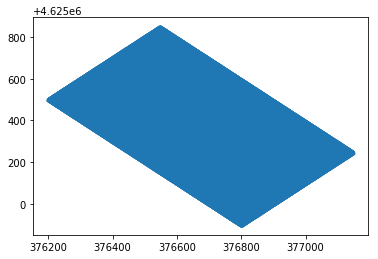

In [9]:
plt.scatter(xu, yu, marker='.')

In [16]:
dsbox = xr.DataArray(np.NaN*np.ones_like(xu))#, coords=[('northing', yu),('easting', xu)])
#dsr = ds.interp(,method='linear')

In [17]:
dsbox

<xarray.DataArray (dim_0: 1201, dim_1: 401)>
array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ..., 
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan]])
Dimensions without coordinates: dim_0, dim_1